In [1]:
!pip install tensorflow


  Obtaining dependency information for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3 from https://files.pythonhosted.org/packages/a7/ad/bf3f358e90b7e70bf7fb520702cb15307ef268262292d3bdb16ad8ebc815/protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.2
    Uninstalling protobuf-5.28.2:
      Successfully uninstalled protobuf-5.28.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
# Define paths
image_dir = r"C:\Users\Zubair\Documents\Javascript\ML\Gulocoma_detection_with_Unet model\Gulocoma_detection_with_Unet model\mask\fundus images"
mask_dir = r"C:\Users\Zubair\Documents\Javascript\ML\Gulocoma_detection_with_Unet model\Gulocoma_detection_with_Unet model\mask\mask"

In [4]:
# Function to load and preprocess images and masks
def load_data(image_dir, mask_dir, target_shape=(512, 512)):
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)]
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and resize image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, target_shape)
        image = image / 255.0  # Normalize
        images.append(image)
        
        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_shape)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load data
images, masks = load_data(image_dir, mask_dir, target_shape=(512, 512))

# Define simplified U-Net architecture
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Contracting Path
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Expansive Path
    up4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Ensure dtype is float32
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure dtype is float32
    
    # Flatten the tensors
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    
    # Add epsilon to the denominator to avoid division by zero
    return (2. * intersection + epsilon) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) + epsilon)



def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)





Training started...
Epoch 1/2
3/3 [==============================] - 24s 7s/step - loss: 0.1249 - dice_coefficient: 0.8773
Epoch 2/2
3/3 [==============================] - 20s 6s/step - loss: 0.0630 - dice_coefficient: 0.9399


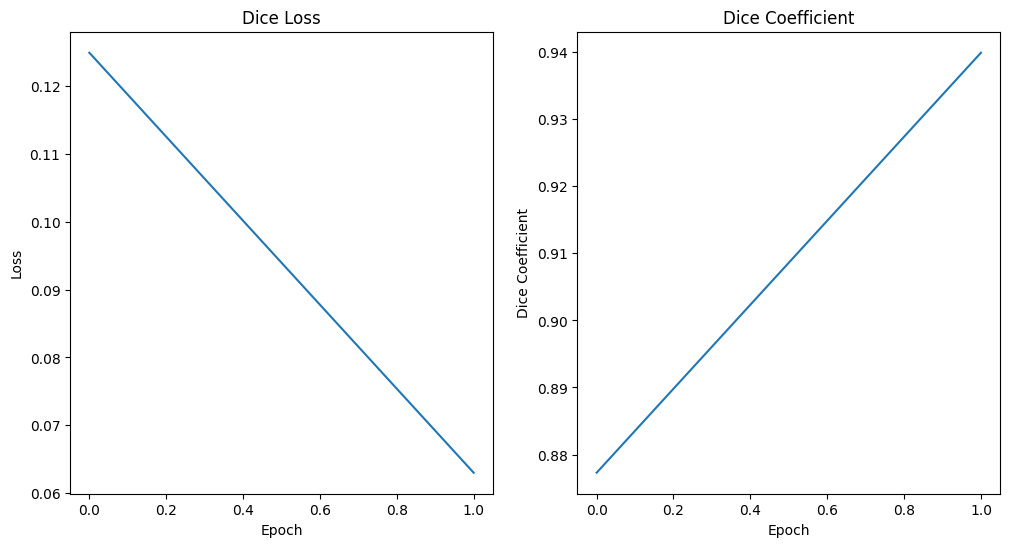

In [5]:
import matplotlib.pyplot as plt
#from tensorflow.keras import layers, models

# Compile the model with Dice loss
model = unet_model(input_shape=(512, 512, 3))
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

# Train the model
print("Training started...")
history = model.fit(images, masks, epochs=2, batch_size=4, verbose=1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'])
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')

plt.show()

In [6]:
# Evaluate model
evaluation = model.evaluate(images, masks, verbose=1)
print(f"Dice Loss: {evaluation[0]}")
print(f"Dice Coefficient: {evaluation[1]}")

# Save the trained model
#model.save('optic_disc_cup_segmentation_model.h5')



1/1 [==============================] - 3s 3s/step - loss: -0.0470 - dice_coefficient: 1.0470
Dice Loss: -0.0470353364944458
Dice Coefficient: 1.0470353364944458


In [7]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

# Define evaluation functions
def compute_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten())

def compute_precision(y_true, y_pred):
    return precision_score(y_true.flatten(), y_pred.flatten())

def compute_recall(y_true, y_pred):
    return recall_score(y_true.flatten(), y_pred.flatten())

def compute_iou(y_true, y_pred):
    return jaccard_score(y_true.flatten(), y_pred.flatten())

# Load ground truth masks and predicted masks

# Assuming you have loaded the masks already
predicted_masks = model.predict(images)  # Replace 'model' and 'images' with your actual variables


# Binarize masks
def binarize_masks(masks):
    return (masks > 0).astype(int)

# Binarize ground truth masks and predicted masks
binarized_ground_truth_masks = binarize_masks(masks)
binarized_predicted_masks = binarize_masks(predicted_masks)

# Compute metrics
accuracy = compute_accuracy(binarized_ground_truth_masks, binarized_predicted_masks)
precision = compute_precision(binarized_ground_truth_masks, binarized_predicted_masks)
recall = compute_recall(binarized_ground_truth_masks, binarized_predicted_masks)
iou = compute_iou(binarized_ground_truth_masks, binarized_predicted_masks)

# Print the computed metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Intersection over Union (IoU):", iou)


1/1 [==============================] - 4s 4s/step
Accuracy: 0.020625027743252842
Precision: 0.020625027743252842
Recall: 1.0
Intersection over Union (IoU): 0.020625027743252842


1/1 [==============================] - 4s 4s/step


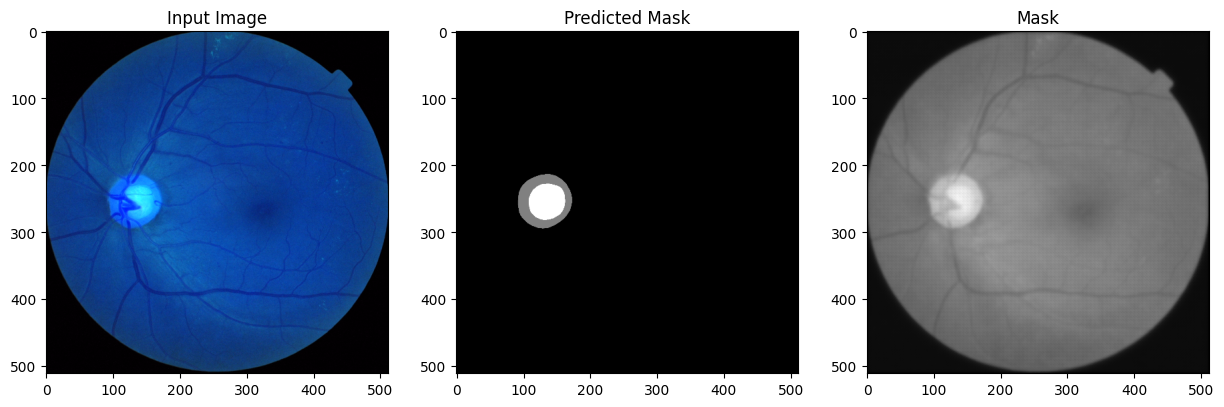

In [10]:
# Visualize segmentation results
predicted_masks = model.predict(images)

# Choose a random sample
#idx = np.random.randint(0, len(images))
idx=6

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(images[idx])
plt.title('Input Image')

plt.subplot(1, 3, 3)
plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
plt.title('Mask')

plt.subplot(1, 3, 2)
plt.imshow(masks[idx], cmap='gray')
plt.title('Predicted Mask')


plt.show()

In [11]:
od_area = np.sum(masks[idx])  # Assuming the OD region is white in the mask

# Predict masks
#predicted_masks = model.predict(images[idx])

# Calculate area of segmented OC region
oc_area = np.sum(predicted_masks[idx])  # Assuming the OC region is white in the predicted mask

# Calculate CDR
cdr = oc_area / od_area
print("Cup-to-Disc Ratio (CDR):", cdr)

Cup-to-Disc Ratio (CDR): 0.1510441882814954


In [12]:
if cdr>0.400000:
    print("Glaucoma Detected!")
else:
    print("Glaucoma Not Detected!")
  

Glaucoma Not Detected!
